In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.plotsiii import plotiii1, plotiii2
from src.plotsv import plotv1, plotv2

### Tensorflow HMC 

In [3]:
from corner import corner
import tensorflow as tf
import tensorflow_probability as tfp

tdf = tfp.distributions

In [4]:
# set seed
np.random.seed(120420)
tf.random.set_seed(120420)

# read text file
file_path = 'src/lighthouse_flash_data.txt'

# Read the data
def read_data(file_path):
    '''
    Function to read data from a text file and return it as two lists.
    '''
    # initialise lists to store the data
    column1 = []  
    column2 = []  
    
    with open(file_path, 'r') as file:  # Open the file for reading
        for line in file:  # Iterate over each line in the file
            parts = line.split()  # Split the line by whitespace
            
            # Append the parts to their respective column lists
            column1.append(float(parts[0]))
            column2.append(float(parts[1]))

    return column1, column2


In [5]:
# observed flashes
x_observed = np.array(read_data(file_path)[0], dtype=np.float32)

# constants for the uniform prior
a = -3
b = 2
c = 0.5
d = 5
'''a = -1.5
b = 0.5
c = 1
d = 3'''


# joint log probability function
def joint_log_prob(x, alpha, beta):
    # likelihood
    likelihood = tdf.Cauchy(loc=alpha, scale=beta).log_prob(x)
    log_likelihood = tf.reduce_sum(likelihood)

    # prior
    log_prior_alpha = tf.where(
        tf.logical_and(alpha > a, alpha < b),
        tf.math.log(1/(b-a)),
        -np.inf
    
    )
    log_prior_beta = tf.where(
        tf.logical_and(beta > c, beta < d),
        tf.math.log(1/(d-c)),
        -np.inf
    )

    return log_prior_alpha + log_prior_beta + log_likelihood

# Define the unnormalized posterior (target distribution)
def unnormalized_posterior(alpha, beta):            
    return joint_log_prob(x_observed, alpha, beta)


In [10]:
# nuts kernel
nuts_kernel = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=unnormalized_posterior,
    step_size=np.float64(0.008) #0.005 
)

num_burnin_steps = 100
# Adpative step size
num_adaptation_steps = int(num_burnin_steps * 0.8)
adaptive_nuts = tfp.mcmc.SimpleStepSizeAdaptation(
  nuts_kernel,
  num_adaptation_steps=int(num_adaptation_steps),
  target_accept_prob=np.float64(0.75))


# run hmc
@tf.function
def run_chain(initial_state, num_results=3000, num_burnin_steps=num_burnin_steps): # 30000, 300
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_nuts,
      trace_fn=lambda current_state, kernel_results: kernel_results)
  return samples, kernel_results

# Number of chains and initial values
num_chains = 8
''''
initial_alpha = np.random.uniform(low=a, high=b, size=(num_chains, 1)).astype(np.float32)  # Shape [num_chains, 1]
initial_beta = np.random.uniform(low=c, high=d, size=(num_chains, 1)).astype(np.float32)  # Shape [num_chains, 1]
'''
initial_alpha = tf.random.uniform([num_chains, 1], minval=a, maxval=b)  # Shape [num_chains, 1]
initial_beta = tf.random.uniform([num_chains, 1], minval=c, maxval=d)  # Shape [num_chains, 1]

# Combine initial states
initial_state = [initial_alpha, initial_beta]

# Run the chains
samples, kernel_results = run_chain(initial_state=initial_state)
alpha_samples, beta_samples = samples


In [7]:
'''import tensorflow as tf

# Assuming alpha_samples and beta_samples are defined and have the shape (50000, 8, 1)
combined_samples = tf.concat([alpha_samples, beta_samples], axis=-1)
combined_samples

from zeus import AutoCorrTime

taus = AutoCorrTime(np.array(combined_samples))
print('Autocorrelation:', taus)

tau = max(taus)
print(f"{tau = }")
'''

'import tensorflow as tf\n\n# Assuming alpha_samples and beta_samples are defined and have the shape (50000, 8, 1)\ncombined_samples = tf.concat([alpha_samples, beta_samples], axis=-1)\ncombined_samples\n\nfrom zeus import AutoCorrTime\n\ntaus = AutoCorrTime(np.array(combined_samples))\nprint(\'Autocorrelation:\', taus)\n\ntau = max(taus)\nprint(f"{tau = }")\n'

In [11]:
# Assuming alpha_samples and beta_samples are your MCMC outputs
# First, remove the unnecessary middle dimension (which is 1 in your case)
alpha_flat = alpha_samples.numpy().squeeze()  # This changes shape from (300, 1, 1) to (300,)
beta_flat = beta_samples.numpy().squeeze()  # Same here

# Stack alpha and beta samples along a new axis to get the correct shape
samples_np = np.stack([alpha_flat, beta_flat], axis=-1)  # This should give you a shape of (300, 2)

# mean and std of alpha and beta
mean_alpha = np.mean(alpha_samples)
std_alpha = np.std(alpha_samples)

mean_beta = np.mean(beta_samples)
std_beta = np.std(beta_samples)

print('alpha:', mean_alpha, std_alpha)
print('beta:', mean_beta, std_beta)

alpha: -0.39847383 0.5138356
beta: 1.6433425 0.32238975


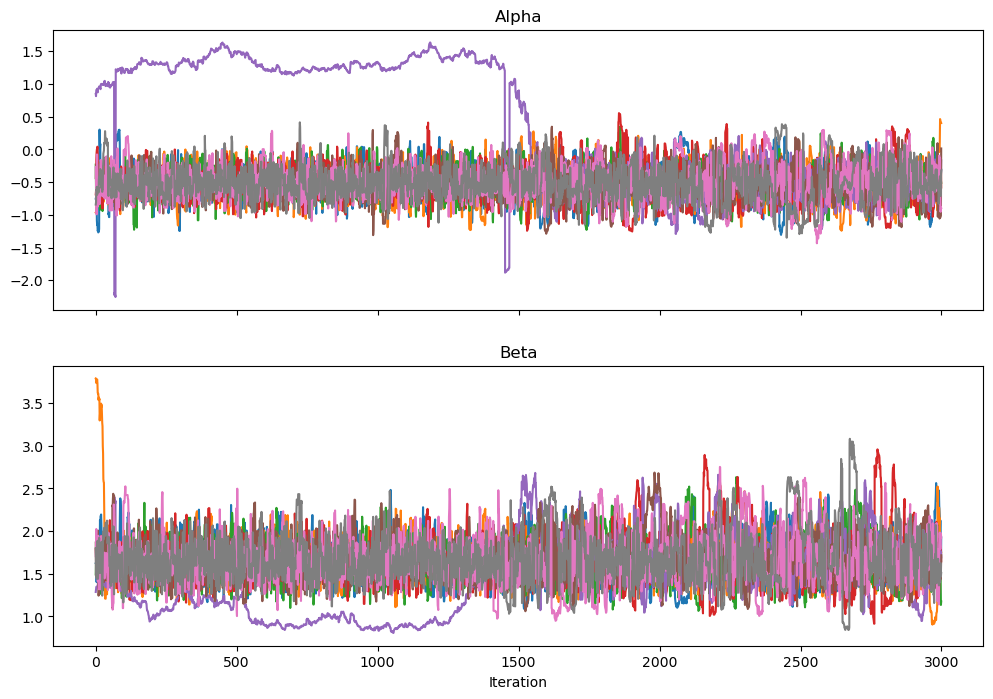

In [12]:
# plot alpha and beta samples
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
axes[0].plot(alpha_flat)
axes[0].title.set_text('Alpha')
axes[1].plot(beta_flat)
axes[1].title.set_text('Beta')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('')


plt.show()


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (3000) than draws (8). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


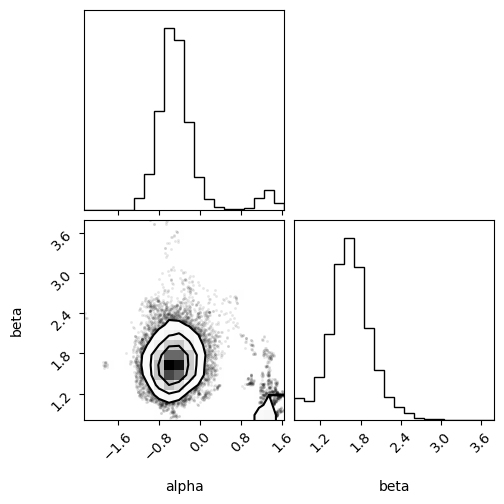

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import corner


# Now, use the corner plot
corner.corner(samples_np, labels=['alpha', 'beta'])
plt.show()


In [14]:
alpha_flat

array([[-0.75214684, -0.96683246, -0.23264821, ..., -0.43809474,
        -0.27216026, -0.84213436],
       [-0.7530998 , -0.96467364, -0.6056403 , ..., -0.24886264,
        -0.42308992, -0.80524665],
       [-0.42647928, -0.902652  , -0.6020441 , ..., -0.24886264,
        -0.47506183, -0.6202296 ],
       ...,
       [-0.6248052 ,  0.42150623, -0.7042758 , ..., -1.0265666 ,
        -0.9525314 , -0.7108206 ],
       [-0.37252548,  0.41439608, -0.4715006 , ..., -1.0100452 ,
        -0.878753  , -0.41287604],
       [-0.31078267,  0.40223214, -0.5101904 , ...,  0.01416577,
        -0.89624316, -0.32249478]], dtype=float32)

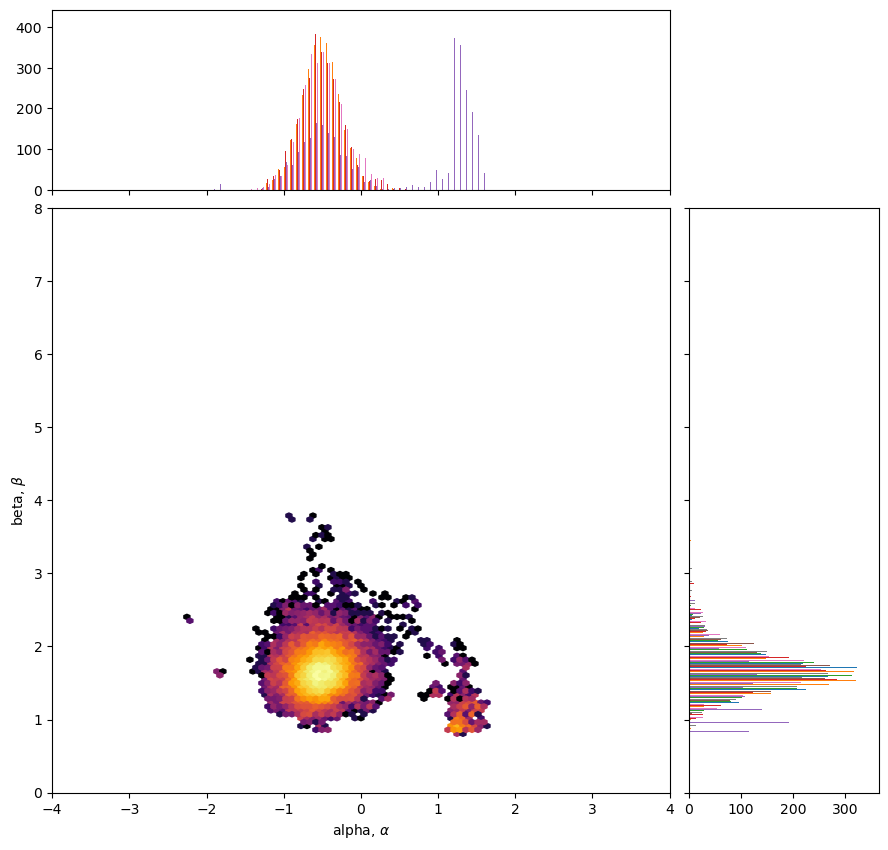

In [15]:
samples_flat = alpha_flat, beta_flat
xrange = a, b
yrange = c, d
plotv1(samples_flat, xrange, yrange)

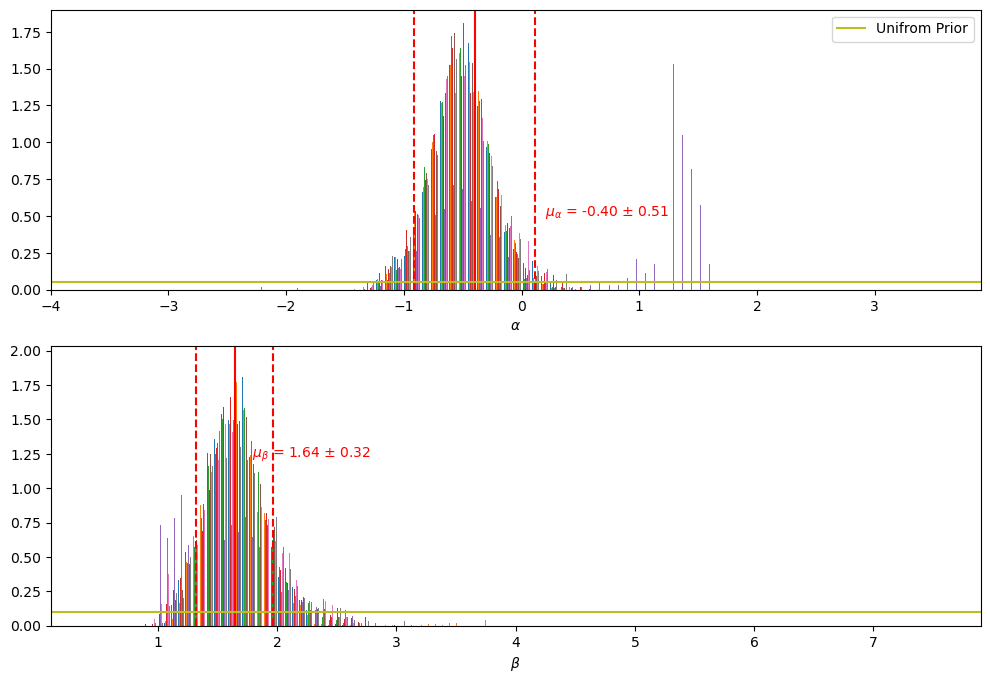

In [16]:
plotv2(samples_flat, xrange, yrange)

In [17]:
hmc_kernel_results = kernel_results.inner_results


r_hat = tfp.mcmc.potential_scale_reduction(samples)
print("Acceptance rate:", hmc_kernel_results.is_accepted.numpy().mean())
r_hat_numpy = [tensor.numpy() for tensor in r_hat]

# Now you can print the r_hat values
print("R-hat diagnostic (per latent variable):", r_hat_numpy)


Acceptance rate: 0.962
R-hat diagnostic (per latent variable): [array([1.6233313], dtype=float32), array([1.0945847], dtype=float32)]


In [ ]:
from zeus import AutoCorrTime
'''
taus = AutoCorrTime(np.array())
print('Autocorrelation:', taus)

tau = max(taus)
print(f"{tau = }")'''


ValueError: not enough values to unpack (expected 3, got 2)

In [35]:
import emcee
import numpy as np

# Let's assume you have two parameters and samples_flat is a list of two arrays.
# Each array is (chains, steps) for each parameter.
# You need to reshape or transpose this to (steps, chains) for each parameter to use emcee's autocorr function.

autocorr_times = []
for param_samples in samples_flat:
    # Transpose to make it (steps, chains)
    param_samples_T = param_samples.T
    
    # Compute the autocorrelation time for this parameter
    tau = emcee.autocorr.integrated_time(param_samples_T, tol=0)

    autocorr_times.append(tau)

# autocorr_times now contains the autocorrelation times for each parameter
print("Autocorrelation times (per parameter):", autocorr_times)


[[-0.2715825  -0.2715825  -0.28152156 ... -0.5440176  -0.5207121
  -0.5207121 ]
 [ 0.7321381   0.6876632   0.6876632  ... -0.32191107 -0.28368443
  -0.2722708 ]
 [-0.2653303  -0.2653303  -0.37031537 ...  0.24115798  0.24115798
   0.24115798]
 ...
 [-1.0696919  -1.1040255  -1.0597852  ... -0.06881577 -0.09984477
  -0.12237839]
 [-0.7768194  -0.7768194  -0.81883985 ...  0.02992835  0.06111517
   0.07687815]
 [ 0.01119944 -0.12542285 -0.12542285 ... -0.3021453  -0.30342537
  -0.27253523]]
[[1.4662117 1.4662117 1.4684144 ... 1.6842138 1.7092478 1.7092478]
 [1.2701985 1.2501838 1.2501838 ... 1.3503587 1.3108748 1.2848325]
 [2.613018  2.613018  2.5957434 ... 1.5282753 1.5282753 1.5282753]
 ...
 [2.0249867 1.991288  1.993304  ... 2.158268  2.1943662 2.2103271]
 [1.409937  1.409937  1.3715417 ... 1.3821226 1.3880816 1.3465804]
 [1.1223954 1.035262  1.035262  ... 1.8494813 1.8286924 1.7943515]]
Autocorrelation times (per parameter): [array([0.35728384]), array([0.45497248])]


In [32]:
thinned_chains = chains.numpy()[::2*int(tau)]

a,b,c = thinned_chains.shape
iid_tf_samples = thinned_chains.reshape(a*b, c)

num_samples = len(iid_tf_samples)

print("Number of i.i.d. samples produced = {}".format(num_samples))
print("Time taken per i.i.d. sample = {}s".format((t_end-t_start)/num_samples))

NameError: name 'chains' is not defined